In [116]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

In [117]:
def main ():
    file = 'disney_plus_titles.csv'
    
    #Extracting data form CVS filr
    data = extract_data(file)

    #clean data and save it for the future analysises
    cleaned_data = modify(data)
    cleaned_data.to_csv('cleaned_disney_plus_data.csv', index=False)

    db_disney = 'disney_plus_db.sqlite'
    table_name = 'database'
    
    #Loading cleaned data into SQLite
    into_sqlite(cleaned_data, db_disney, table_name)

    best_types, longest, classification = analysis(cleaned_data)

    visualization (best_types, longest, classification)

    

In [118]:
def extract_data(file):
    return pd.read_csv(file)

In [119]:
def modify(data):
    data['date_added'] = pd.to_datetime(data['date_added'])
    data['release_year'] = data['date_added'].dt.year
    data['duration'] = data['duration'] = data['duration'].str.extract('(\d+)').astype(float)
    data.drop('cast', axis=1, inplace=True)
    data['director'].fillna('Unknown', inplace=True)
    data['listed_in'] = data['listed_in'].apply(', '.join)
    #Scale the rating
    rating = {
        'G': 0,
        'PG': 1,
        'PG-13': 2,
        'R': 3,
        'NC-17': 4
    }
    data['classification'] = data['rating'].map(rating)
    return data


In [120]:
def into_sqlite(data, db_disney, table_name):
    conn = sqlite3.connect(db_disney)
    data.to_sql('database', conn, if_exists='replace', index=False)
    conn.close()

In [121]:
def sql (db_disney):
    connection = sqlite3.connect(db_disney)
    
    # 5 most popular genres
    genres = """
    SELECT listed_in, COUNT(*) AS genre_count
    FROM database
    GROUP BY listed_in
    ORDER BY genre_count DESC
    LIMIT 5;
    """
    mp_genres = pd.read_sql(genres, connection)

    # 5 most popular countries
    countries = """
    SELECT country, COUNT(*) AS country_count
    FROM database
    WHERE country != 'N/A'
    GROUP BY country
    ORDER BY country_count DESC
    LIMIT 5;
    """

    mp_countries = pd.read_sql(countries, connection)

    # 5 most popular directors

    directors = """
    SELECT director, COUNT(*) AS director_count
    FROM database
    WHERE director != 'N/A'
    GROUP BY director
    ORDER BY director_count DESC
    LIMIT 5;
    """

    mp_directors = pd.read_sql(directors, connection)

    connection.close()

    return mp_countries, mp_genres, mp_directors



In [122]:
def analysis (data):
    longest = data.nlargest(10, 'duration')
    classification = data['rating'].value_counts().sort_values(ascending=False)
    best_types =data['type'].value_counts().idxmax()
    data['listed_in'] = data['listed_in'].apply(lambda x: x.split(', '))
    best_types = data['type'].value_counts().reset_index()
    best_types.columns = ['type', 'type_count']

    return best_types, longest, classification


In [123]:
def visualization (best_types, longest, classification):
    
    #Visualization for most viewed movies and TV shows
    best_ratings=plt.figure(figsize=(12,8))
    classification.plot(kind='bar', color = 'blue')
    plt.xlabel('rating')
    plt.ylabel('Number of TV shows and movies')
    plt.title('The most popular rating')
    plt.xticks(rotation = 0)
    plt.tight_layout()
    best_ratings.savefig('views.jpg')

    #The longest TV shows and movies
    duration = plt.figure(figsize=(12, 8))
    plt.plot(longest['title'], longest['duration'], color='red', marker='s')
    plt.xlabel('Title')
    plt.ylabel('Duration (minutes)')
    plt.title('The longest movies')
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    duration.savefig('duration.jpg')

    #Visualization for most watched types 
    types= plt.figure(figsize = (12,8))
    plt.bar(best_types['type'], best_types['type_count'], color=['pink', 'orchid'])
    plt.xlabel('Type')
    plt.ylabel('Count')
    plt.title('The most watched types')
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    types.savefig('types.jpg')

    plt.show()



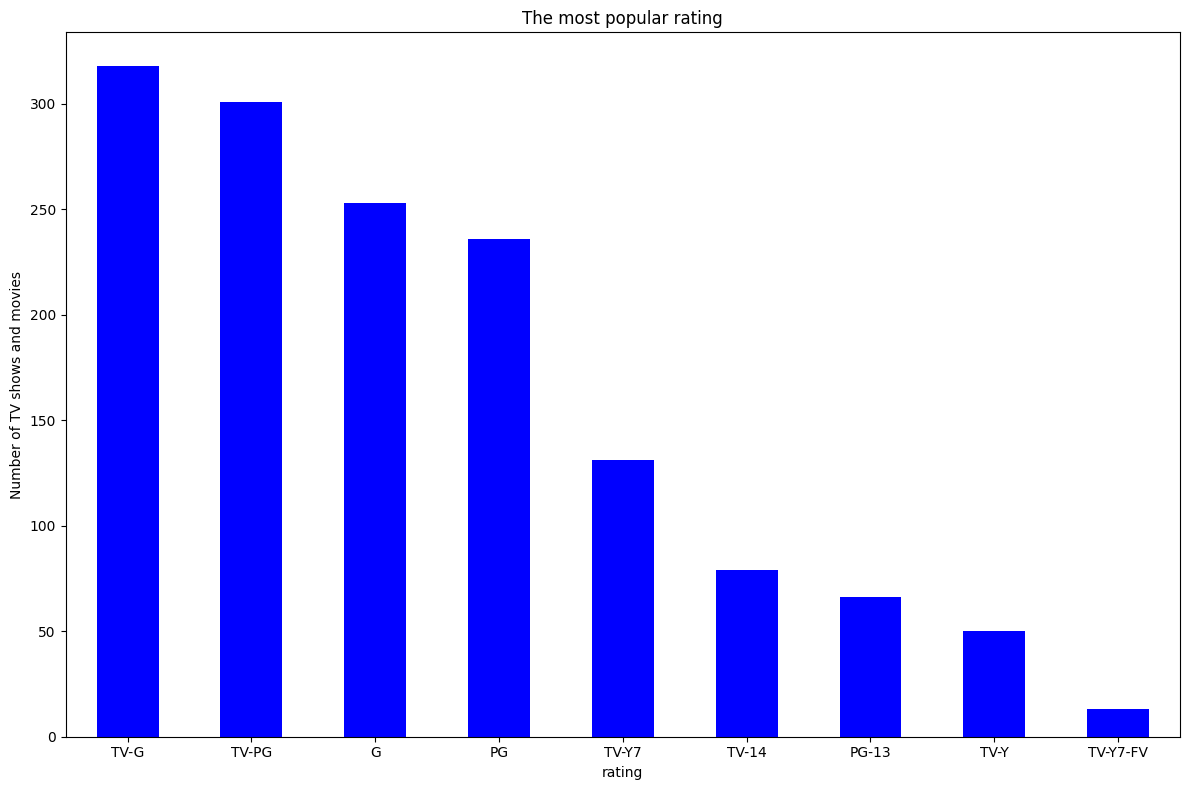

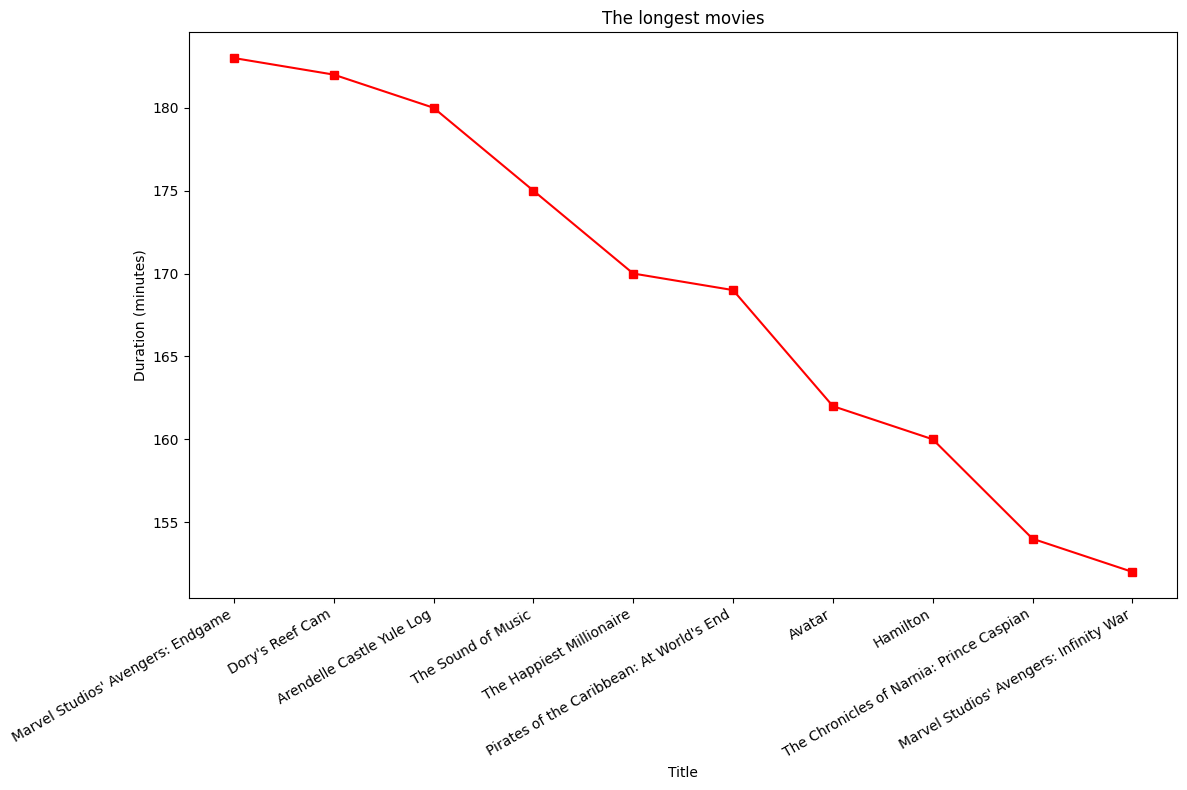

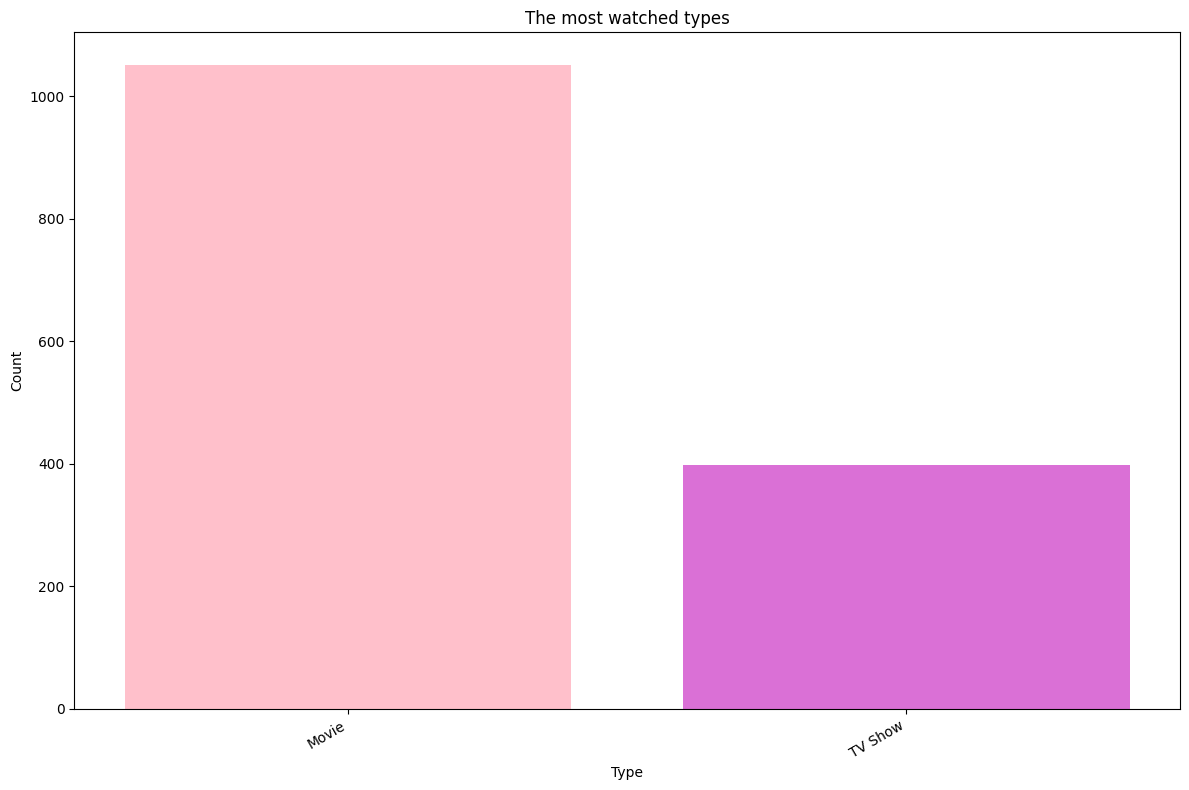

In [124]:
if __name__ == '__main__':
    main()